# THIS ENTIRE NOTEBOOK HAS ONLY PROVEN to me that my indices are still off- my spectrograms are not aligning with my df index. SEe the DCS at teh bottom

# We are missing the females DCs. I am going to find them in the tets. The reason I need a new notebook is because I still am not handling my indices very well and I have two dataframes, one with the right cluster numbers and one with the spectral features and I don't want to go back into the original notebooks to mess with this right now because they're too damn messy

In [3]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
# from soundsig.sound import BioSound 
# from soundsig.sound import WavFile


# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


In [4]:
# base_folder = '/Users/williamwood/Documents/Sound_Localization/for_soundsep/14-38-03_18-07-2023' # old folder
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/"
fs = 48000 # TODO find where to import fs instead of hardcoding it
# Sound_Localization/for_soundsep/7_18_23__09_29_44'

# file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
file_name = os.path.join(base_folder,'_appdata','save','segments_exclude_short_gaps.csv')

print(file_name)

df = pd.read_csv(file_name, sep=',',header=0, index_col=0)        
print(f'Length of dataframe: {len(df)}')
print(f'Column names: {df.columns}')
print(f'Tags: {df["Tags"].unique()}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments_exclude_short_gaps.csv
Length of dataframe: 3553
Column names: Index(['SourceName', 'SourceChannel', 'StartIndex', 'StopIndex', 'Tags',
       'cluster', 'coords', 'gap_duration'],
      dtype='object')
Tags: ['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


In [5]:
df['StartIndex'][0]/fs
# df['Tags'] = df['Tags'].apply(lambda x: x[2:-2]) # old technique doesn't work for all
# df.loc[df['Tags'] == '','Tags'] = 'tet' # replace empty tags with 'tet' (not perfect but ok)
df['Bird_ID'] = df['SourceName']
df['StartIndex_in_sec'] = df['StartIndex']/fs
df['EndIndex_in_sec'] = df['StopIndex']/fs

# make a new df column that is the length of the segment in seconds
df['length'] = (df['StopIndex']-df['StartIndex'])/fs

# print(df['Tags'].unique())
print(df['Bird_ID'].unique())
print(f'Columns: {df.columns}')
print(df[0:10])

['BroGre1354M' 'BluGre1214F' 'WhiWhi6607F' 'WhiWhi1541M']
Columns: Index(['SourceName', 'SourceChannel', 'StartIndex', 'StopIndex', 'Tags',
       'cluster', 'coords', 'gap_duration', 'Bird_ID', 'StartIndex_in_sec',
       'EndIndex_in_sec', 'length'],
      dtype='object')
             SourceName  SourceChannel  StartIndex  StopIndex     Tags  \
Unnamed: 0                                                               
0           BroGre1354M              0      705034     709502  ["tet"]   
1           BluGre1214F              2      739121     741816  ["tet"]   
2           BluGre1214F              2      773851     776369  ["hat"]   
3           BluGre1214F              2      844891     848558  ["tet"]   
6           BroGre1354M              0      938688     943405  ["tet"]   
10          BroGre1354M              0     1169083    1174072  ["tet"]   
14          BroGre1354M              0     1467643    1472313  ["tet"]   
15          BluGre1214F              2     1487256    14903

In [6]:
print(df['Tags'].unique())
df

['["tet"]' '["hat"]' '["3"]' '["call"]' '["DC"]' '["WF"]' '["-2"]' '["8"]'
 '["2"]']


,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,gap_duration,Bird_ID,StartIndex_in_sec,EndIndex_in_sec,length
Unnamed: 0,,,,,,,,,,,,
0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752],NaN,BroGre1354M,14.688208,14.781292,0.093083
1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762],0.710146,BluGre1214F,15.398354,15.454500,0.056146
2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041],0.723542,BluGre1214F,16.121896,16.174354,0.052458
3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248],1.480000,BluGre1214F,17.601896,17.678292,0.076396
6,BroGre1354M,0,938688,943405,"[""tet""]",0.0,[11.827464 10.208561 8.350879],0.479667,BroGre1354M,19.556000,19.654271,0.098271
...,...,...,...,...,...,...,...,...,...,...,...,...
4338,BluGre1214F,2,297295825,297299512,"[""tet""]",5.0,[15.06984 10.02974 4.649854],0.697604,BluGre1214F,6193.663021,6193.739833,0.076813
4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632],0.459917,BluGre1214F,6194.266917,6194.354250,0.087333
4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904],0.878938,BluGre1214F,6195.145854,6195.242583,0.096729


In [7]:
# now I want to sort the long tets from the short tets- the long tets are actually distance calls.
# ideally I would also use spectral features to do this, but my df doesn't have any spectral features.
# I should be able to get them from the other dataframe, we just have to be careful about the indices lining up

spec_filename = os.path.join(base_folder,'spec_results','vocSelTableSprectro.h5')
spec_df = pd.read_hdf(spec_filename)
# read npy file
spectrograms = np.load(os.path.join(base_folder,'spec_results','spectrograms.npy'))
# spectrograms = read(os.path.join(base_folder,'spec_results','spectrograms.npy'))
spectrograms.shape

(4344, 101, 100)

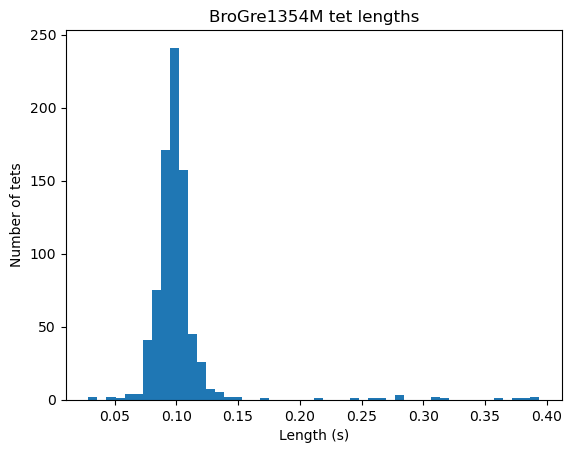

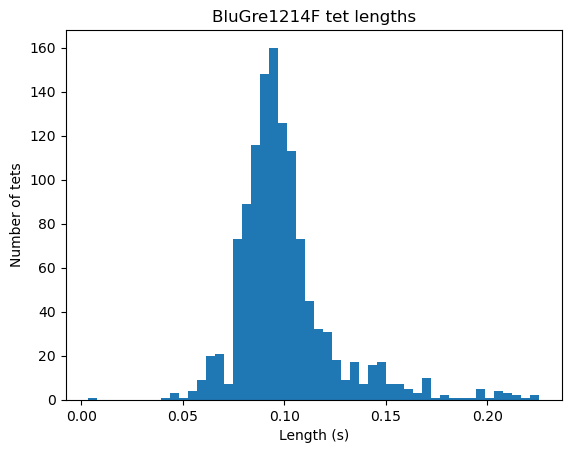

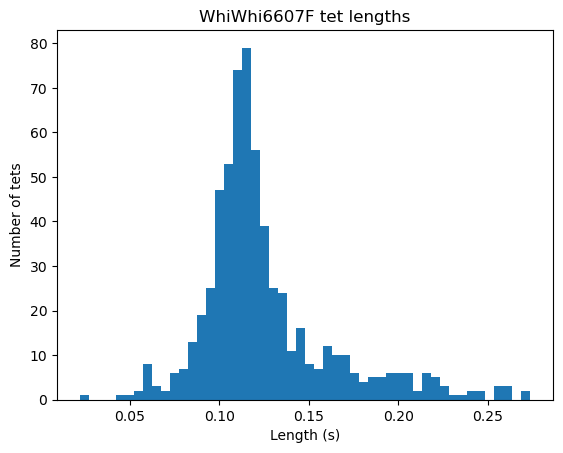

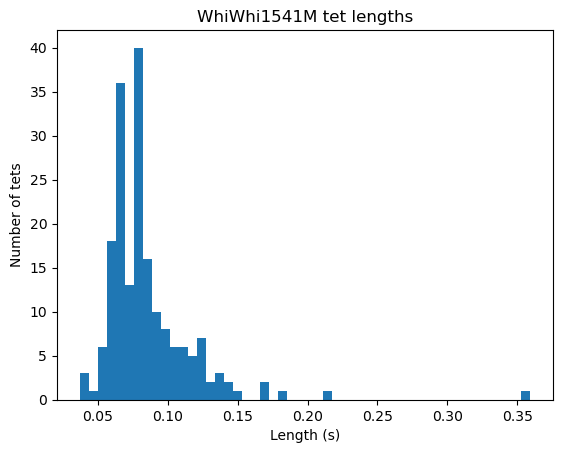

In [8]:
# I am really nervous about the index of the spectrograms lining up with the index of the dataframe 

# what is the average length of a tet for each bird? Actually plot the distribution of tet lengths for each bird
tet_lengths = list()
for bird in df['Bird_ID'].unique():
    tet_lengths = list()
    for i in df.index:
        if df['Bird_ID'][i] == bird:
            if df['Tags'][i] == '["tet"]':
                tet_lengths.append(df['length'][i])
                # if df['length'][i] > 0.15:
                #     print(f'Long tet: {df["length"][i]}')

    plt.hist(tet_lengths, bins=50)
    plt.title(f'{bird} tet lengths')
    plt.xlabel('Length (s)')
    plt.ylabel('Number of tets')
    plt.show()

In [9]:
df

,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,coords,gap_duration,Bird_ID,StartIndex_in_sec,EndIndex_in_sec,length
Unnamed: 0,,,,,,,,,,,,
0,BroGre1354M,0,705034,709502,"[""tet""]",0.0,[11.813441 10.158026 8.204752],NaN,BroGre1354M,14.688208,14.781292,0.093083
1,BluGre1214F,2,739121,741816,"[""tet""]",5.0,[10.289108 8.867108 3.8716762],0.710146,BluGre1214F,15.398354,15.454500,0.056146
2,BluGre1214F,2,773851,776369,"[""hat""]",1.0,[9.031709 7.9875793 2.4193041],0.723542,BluGre1214F,16.121896,16.174354,0.052458
3,BluGre1214F,2,844891,848558,"[""tet""]",5.0,[10.432616 8.651451 3.9261248],1.480000,BluGre1214F,17.601896,17.678292,0.076396
6,BroGre1354M,0,938688,943405,"[""tet""]",0.0,[11.827464 10.208561 8.350879],0.479667,BroGre1354M,19.556000,19.654271,0.098271
...,...,...,...,...,...,...,...,...,...,...,...,...
4338,BluGre1214F,2,297295825,297299512,"[""tet""]",5.0,[15.06984 10.02974 4.649854],0.697604,BluGre1214F,6193.663021,6193.739833,0.076813
4340,BluGre1214F,2,297324812,297329004,"[""tet""]",5.0,[13.918158 10.1539955 3.8789632],0.459917,BluGre1214F,6194.266917,6194.354250,0.087333
4341,BluGre1214F,2,297367001,297371644,"[""tet""]",5.0,[14.02288 10.04855 4.029904],0.878938,BluGre1214F,6195.145854,6195.242583,0.096729


In [10]:
# let's find the long tets of just the females
females = list()
females.append('WhiWhi6607F')
females.append('BluGre1214F')
long_tet_index = list()
for i in df.index:
    if df['Bird_ID'][i] == females[1] and df['Tags'][i] == '["tet"]' and df['length'][i] > 0.15:
        # print(f'Long tet: {df["length"][i]}')
        long_tet_index.append(i)


In [11]:
spectrograms.shape

(4344, 101, 100)

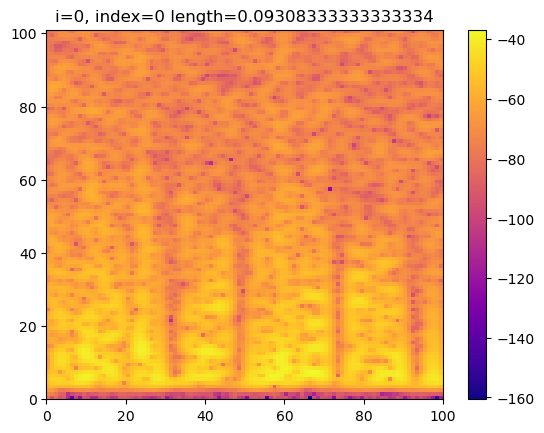

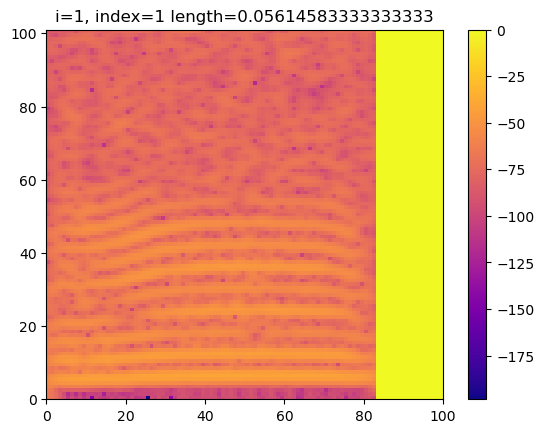

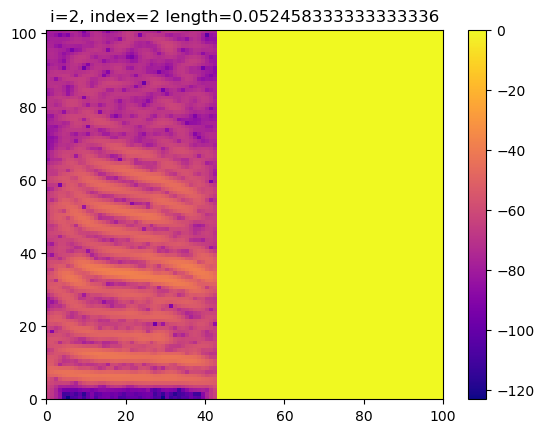

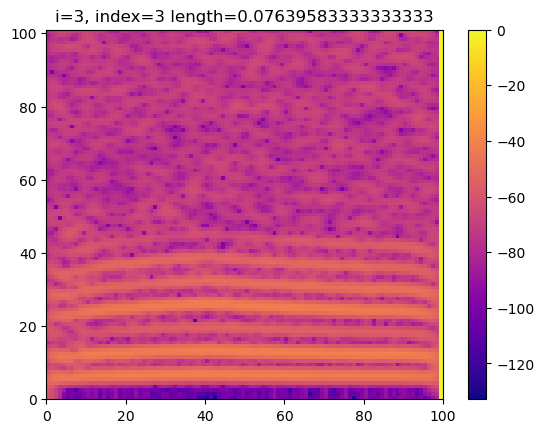

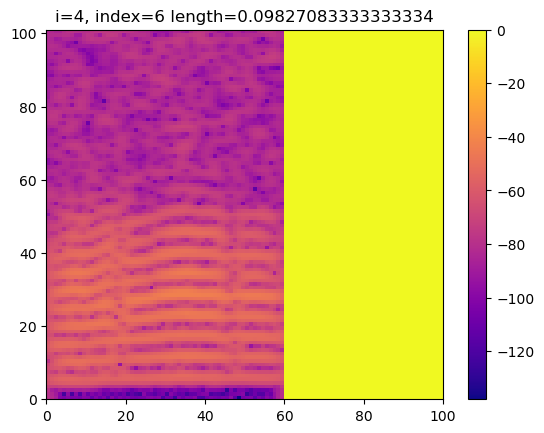

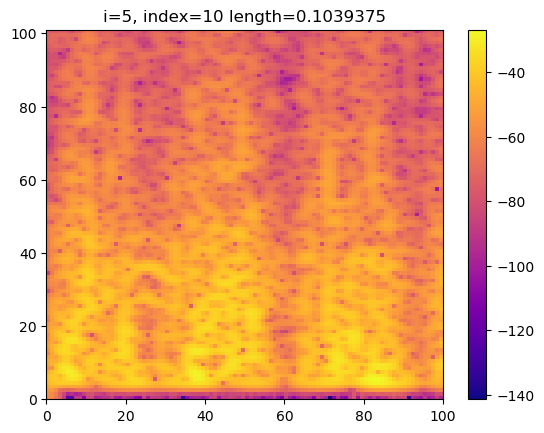

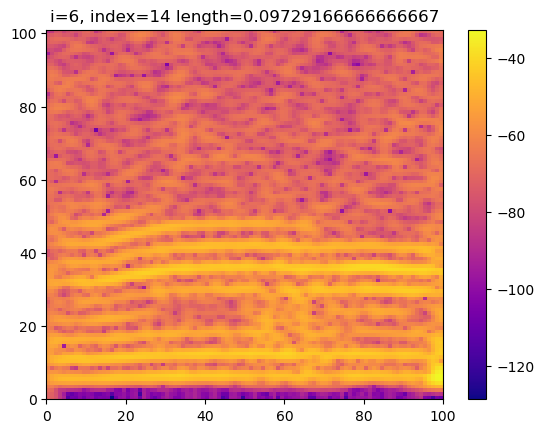

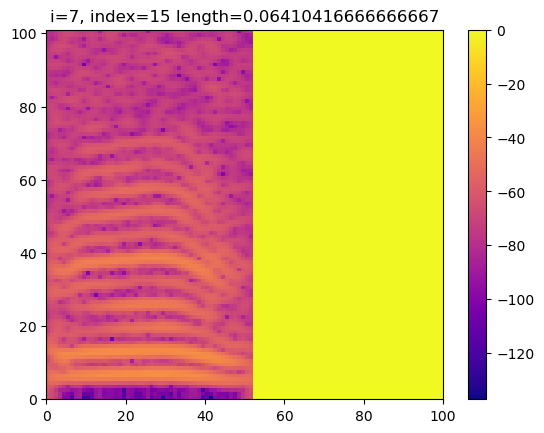

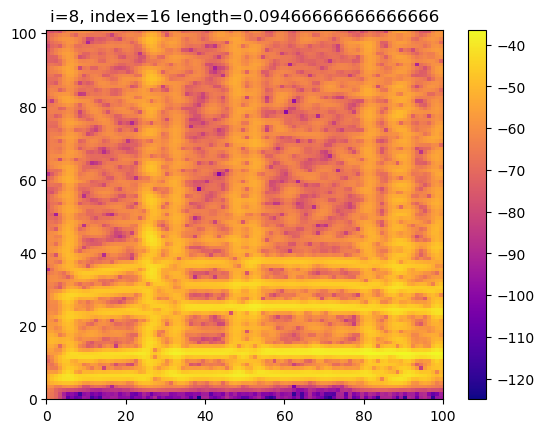

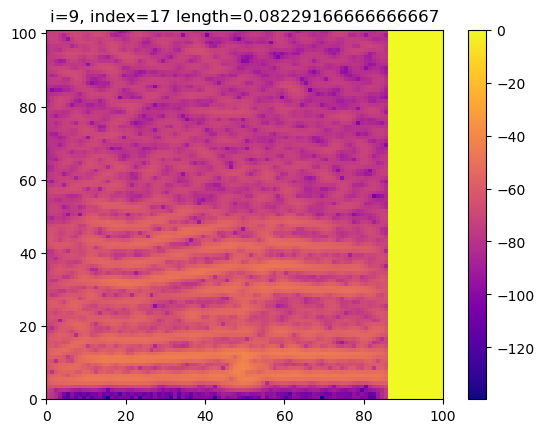

In [12]:
# plot the first 10 spectrograms
for i in range(10):
    spectrogram = spectrograms[i,:,:]
    plt.figure()
    plt.pcolormesh(spectrogram, cmap='plasma', shading='auto')
    plt.title(f'i={i}, index={df.index[i]} length={df.iloc[i]["length"]}')
    plt.colorbar()
    plt.show()

In [16]:
df['Tags'].unique()

array(['["tet"]', '["hat"]', '["3"]', '["call"]', '["DC"]', '["WF"]',
       '["-2"]', '["8"]', '["2"]'], dtype=object)

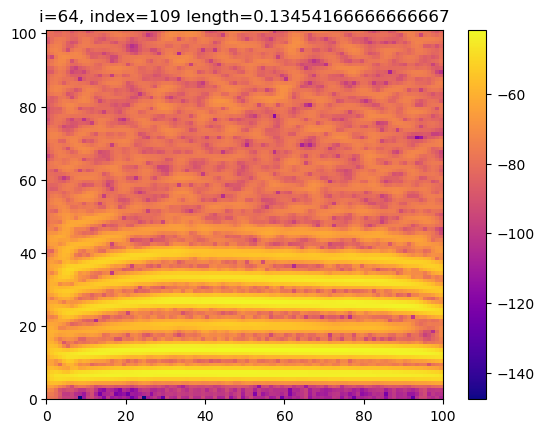

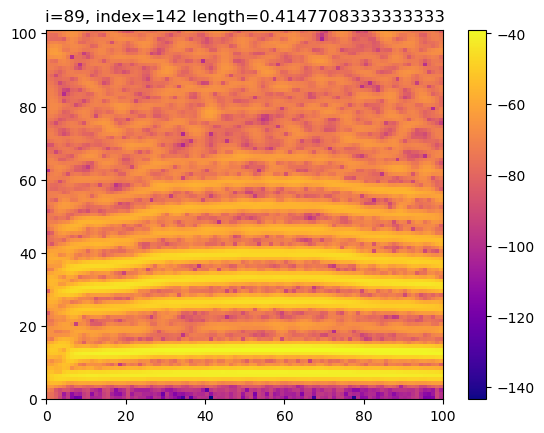

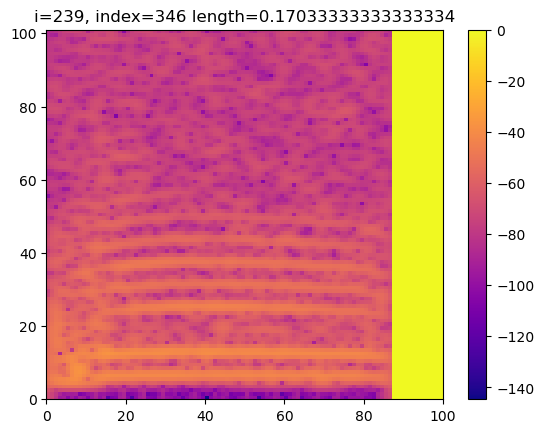

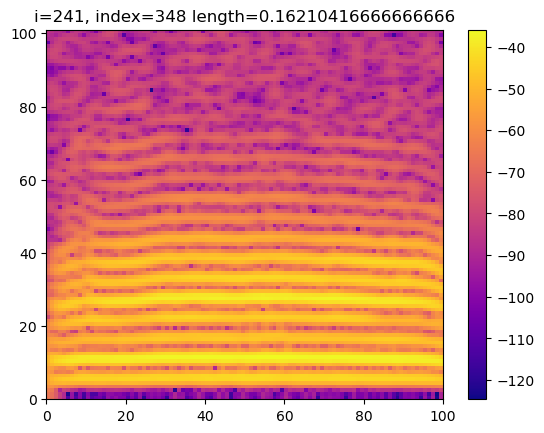

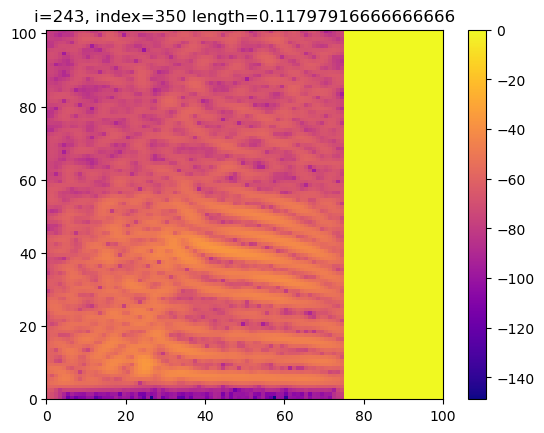

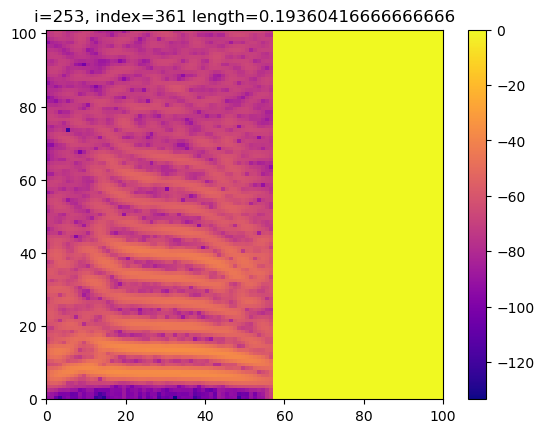

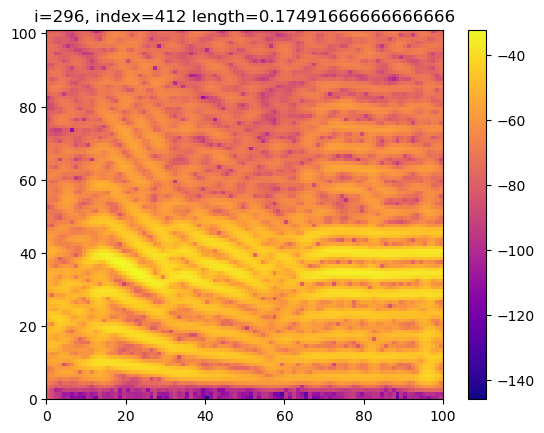

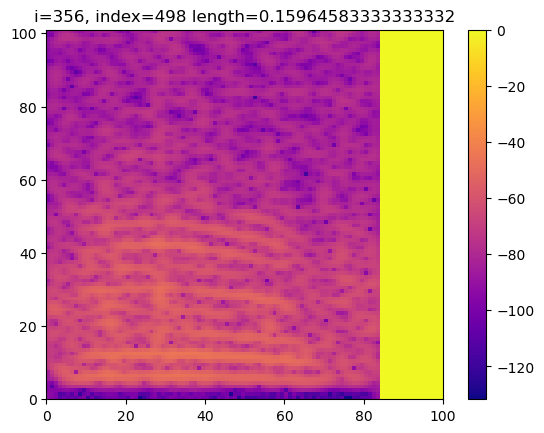

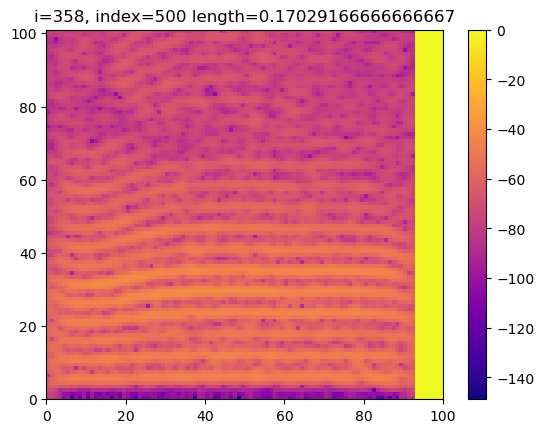

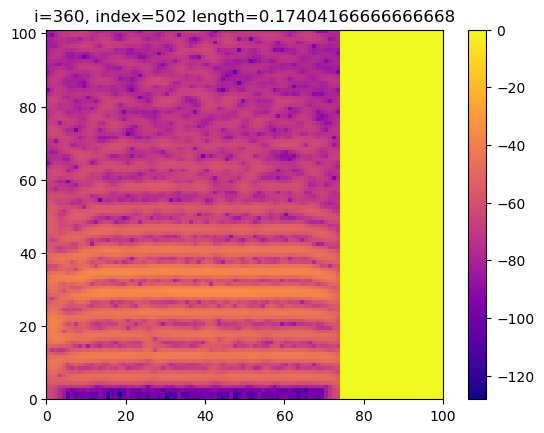

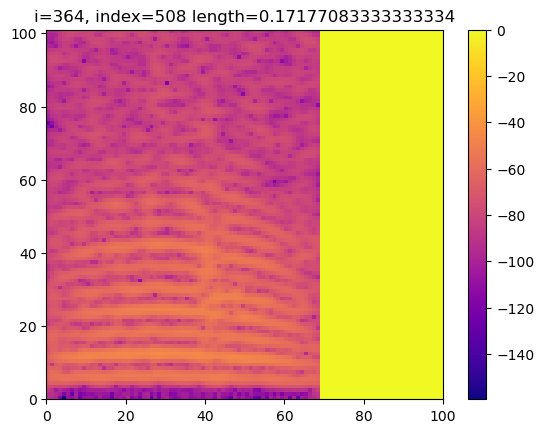

In [17]:
# plot spectrograms of dcs
j = 0
for i in range(len(df)):
    ii = df.index[i]
    if df['Tags'][ii] == '["DC"]':
        spectrogram = spectrograms[ii,:,:]
        plt.figure()
        plt.pcolormesh(spectrogram, cmap='plasma', shading='auto')
        plt.title(f'i={i}, index={df.index[i]} length={df.iloc[i]["length"]}')
        plt.colorbar()
        plt.show()
        j += 1
        if j > 10:
            break

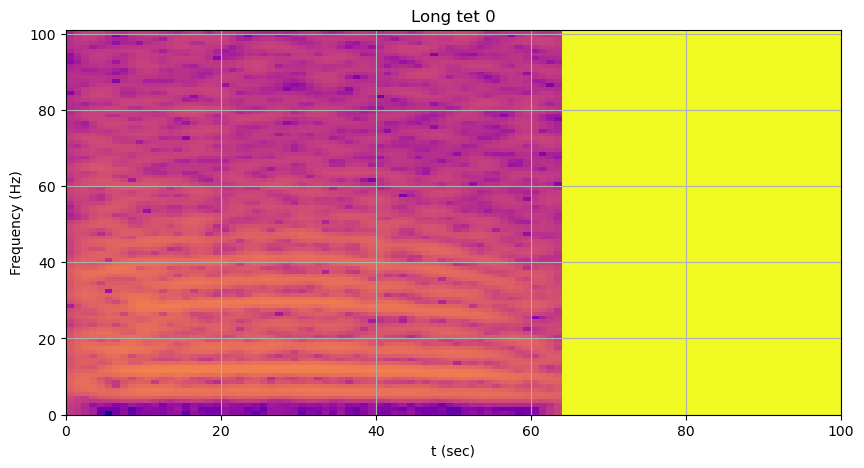

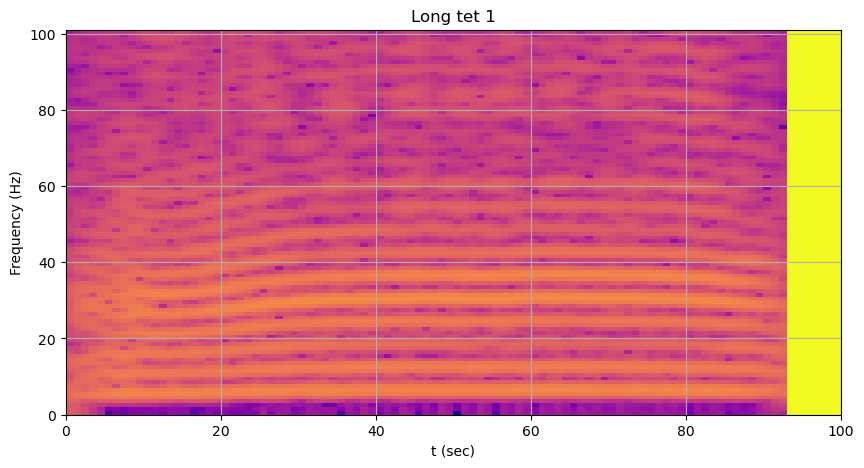

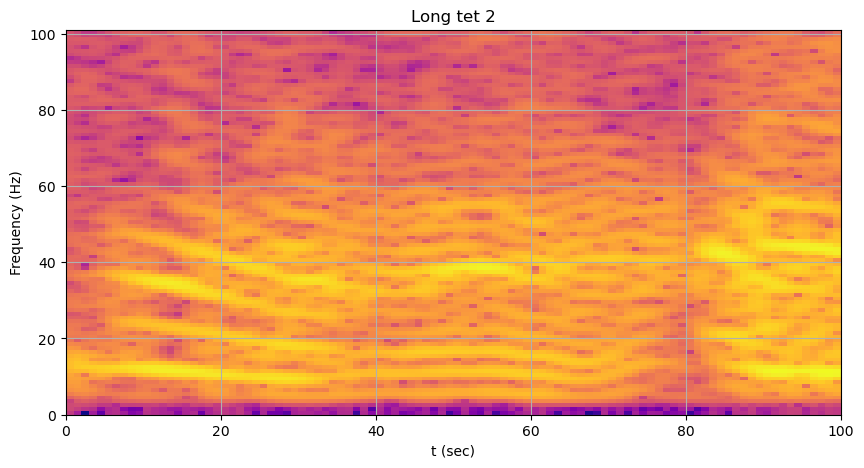

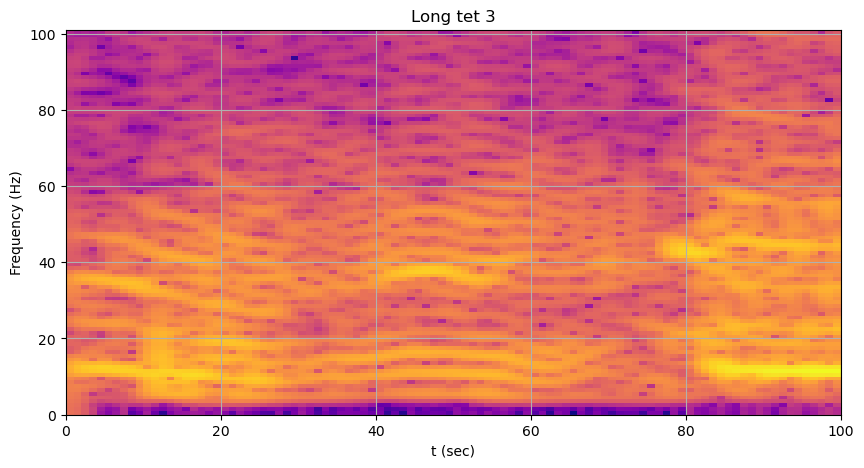

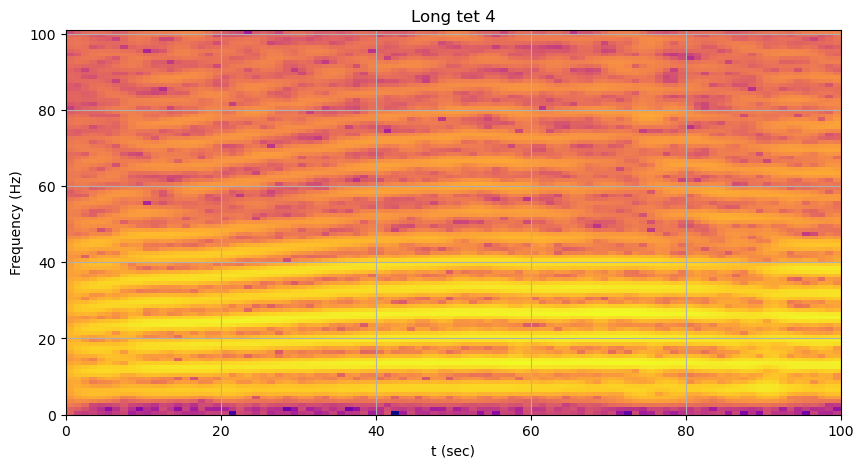

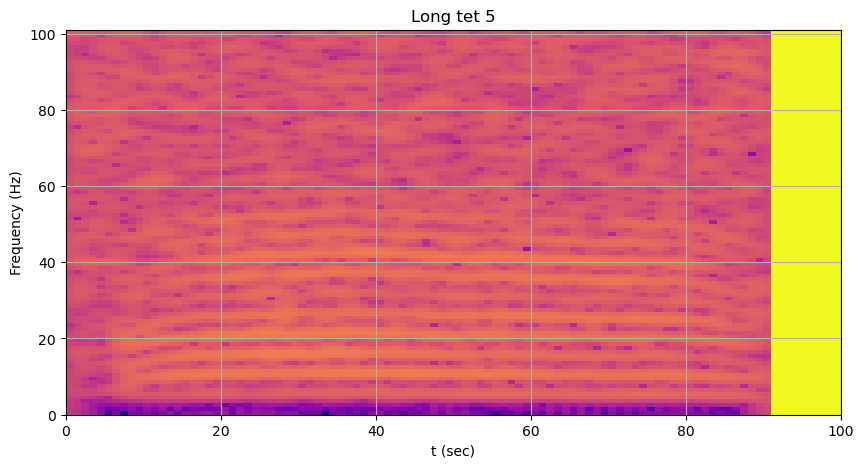

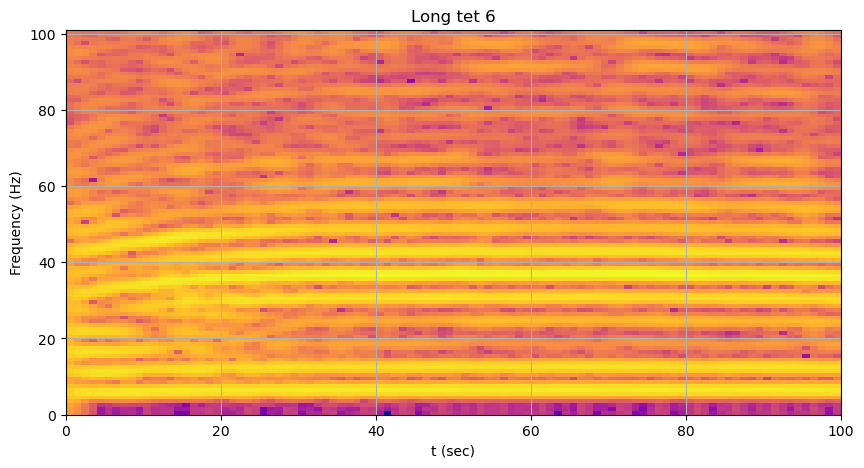

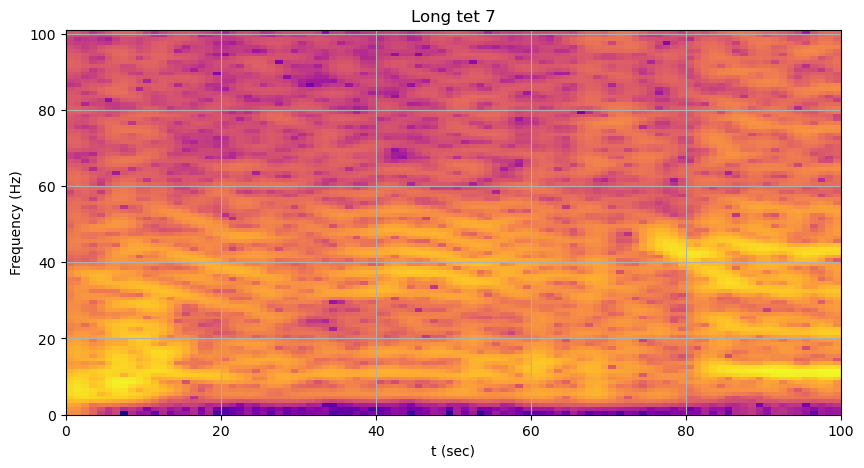

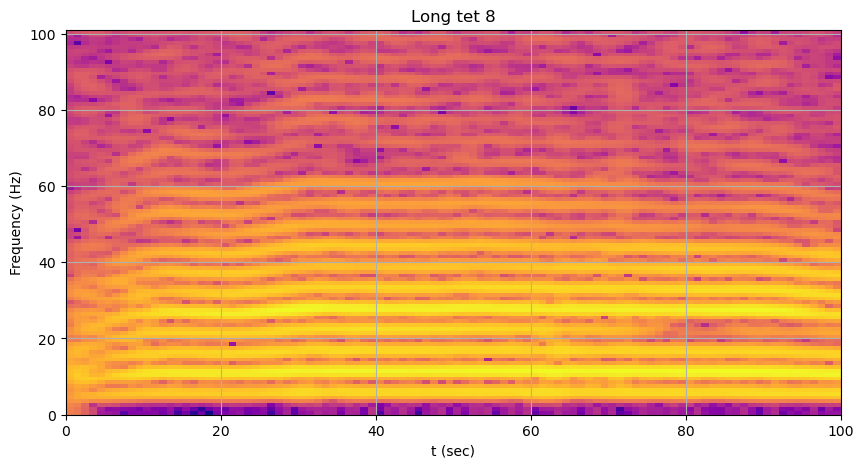

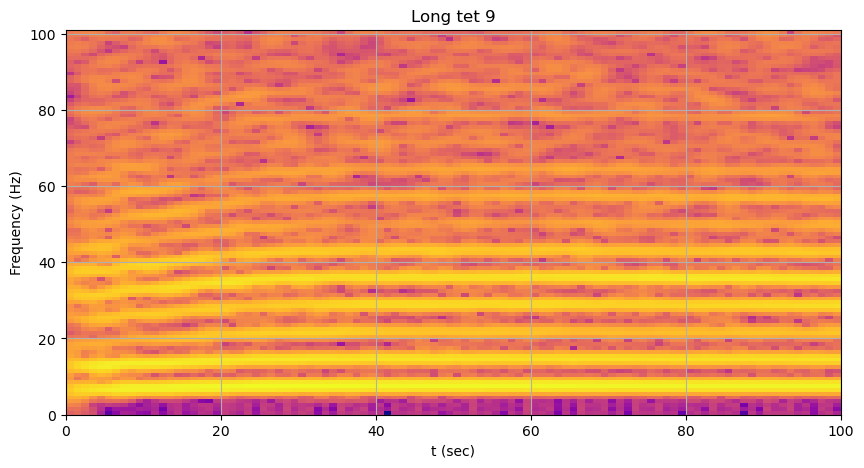

In [13]:
# plot some spectrograms of the long tets
for i in range(10):
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(spectrograms[long_tet_index[i]], cmap='plasma', shading='auto')
    plt.title(f'Long tet {i}')
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()
    plt.show()